# Project 2 Development Notebook: Sentiment and Wellbeing

This file contains development code for project 2 for ECON 1680. It contains all code required to replicate the results outlined in the draft. Inline citations are included for all code segments that are not original. The code first cleans the data, generates some descriptive statistics, and then leverages the methodology discussed in the paper: 

## 1. Imports and Functions

In [21]:
!pip install vaderSentiment


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\garvg\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


In [22]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [23]:
# Add a day to a given date
def plus_day(date):
    return date + pd.Timedelta(days=1)

## 2. Data: Cleaning and Saving

In [24]:
# Path to production directory: note that you must include Data, Figures, and Code subdirectories.
path = "C:\\Users\\garvg\\Downloads\\Project 2\\SentimentWellbeing\\"

# Read in independent Variable CSV data
infl = pd.read_csv(path + "Data\\I.csv")
unempl_rate = pd.read_csv(path + "Data\\URate.csv")
gdp = pd.read_csv(path + "Data\\GDP.csv")
gdp_per_cap = pd.read_csv(path + "Data\\GDPC.csv")
real_gdp = pd.read_csv(path + "Data\\RealGDP.csv")
rgdp_per_cap = pd.read_csv(path + "Data\\RealGDPC.csv")
med_hi = pd.read_csv(path + "Data\\MHI.csv")
rmed_hi = pd.read_csv(path + "Data\\RMHI.csv")

# independent Variables
indeps = [infl, unempl_rate, gdp, gdp_per_cap, real_gdp, rgdp_per_cap, med_hi, rmed_hi]

In [25]:
# Convert date column to datetime objects
for indep in indeps:
    indep["DATE"] = pd.to_datetime(indep["DATE"])

# Period of study determined by the sample of tweets available
#   for information on dataset
max_min_date = pd.to_datetime("01-01-2007") # max([i["DATE"].min() for i in indeps])
min_max_date = pd.to_datetime("01-01-2015") # min([i["DATE"].max() for i in indeps])

# Cut each independent variable to between the minimum and maximum dates
for indep in indeps:
    indep = indep[(indep["DATE"] >= max_min_date) & (indep["DATE"] < min_max_date)]

# Create a date range with this
date_range = pd.Series(pd.date_range(start=max_min_date - pd.Timedelta(days=1), end=min_max_date, freq='3M'))
date_range = date_range.apply(plus_day)

C:\Users\garvg\AppData\Local\Temp\ipykernel_4420\2055520928.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.Series(pd.date_range(start=max_min_date - pd.Timedelta(days=1), end=min_max_date, freq='3M'))


In [26]:
# Create lists of variables 
#   to aggregate (organized at finer granularity than quarterly)
#   to generate (organized at coarser granularity than quarterly, in this case yearly)
#   and other (organized quarterly)
to_aggregate_monthly = [unempl_rate]
to_generate_yearly = [infl, med_hi, rmed_hi]
other = [gdp, gdp_per_cap, real_gdp, rgdp_per_cap]

# To aggregate the finer granularity variables
for i in range(len(to_aggregate_monthly)):
    # Get the given independent variable
    indep = to_aggregate_monthly[i]
    var_name = indep.columns[1]
    
    # Average over the quarterly period and assign these averages to the dataframe
    averaged = indep.groupby(pd.cut(indep["DATE"], date_range, right = False))[var_name].mean()
    to_aggregate_monthly[i] = pd.DataFrame({"DATE": date_range[:-1], var_name: [i for i in averaged]})    

# To fill coarser granularity values
for i in range(len(to_generate_yearly)):
    # Get the given independent variable and the desired columns
    indep = to_generate_yearly[i]
    columns_to_keep = [i for i in indep.columns]
    
    # Generate a year column from the date column of the independent variable
    indep["YEAR"] = indep["DATE"].dt.year

    # Create a dataframe with the desired dates
    date_df = pd.DataFrame({"DATE": date_range})
    # Merge the dataframe with the desired date, where the year of the quarterly date 
    #   matches the year value in the original dataset
    new_indep = pd.merge(date_df, indep, left_on=date_df['DATE'].dt.year, right_on='YEAR', how='left')
    new_indep["DATE"] = new_indep["DATE_x"]
    
    # Cut out non-desired coluns
    to_generate_yearly[i] = new_indep[columns_to_keep]

# Combine the three lists to get the independent variables
indeps = to_aggregate_monthly + to_generate_yearly + other

C:\Users\garvg\AppData\Local\Temp\ipykernel_4420\2954430251.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  averaged = indep.groupby(pd.cut(indep["DATE"], date_range, right = False))[var_name].mean()


In [27]:
# Merge each dataset together to get one dataframe of independent variables
indep_df = indeps.pop()
while indeps != []:
    indep_df = pd.merge(indep_df, indeps.pop(), on="DATE")

# Save this as a csv so we don't have to repeat this pre-processing step
indep_df.to_csv(path + "Data\\independents.csv")

In [28]:
# Import this data to avoid pre-processing independent data
indep_df = pd.read_csv(path + "Data\\independents.csv")
indep_df["DATE"] = pd.to_datetime(indep_df["DATE"])
indep_df = indep_df.drop(columns=["Unnamed: 0"])

### Sentiment Generation

In [29]:
# Read in tweets
tweets_df = pd.read_csv(path + "Data\\tweets.csv", encoding="latin-1")
tweets_df = tweets_df[["created", "text", "user_timezone"]]

# Get date column to merge
tweets_df["DATE"] = pd.to_datetime(tweets_df["created"]).dt.date

# Keep only tweets in US timezones
valid_timezones = ['Eastern Time (US & Canada)', 'Pacific Time (US & Canada)', 'Central Time (US & Canada)', 
                   'Atlantic Time (Canada)', 'Arizona', 'Mountain Time (US & Canada)', 'Hawaii', 'America/Los_Angeles',
                   'Alaska', 'America/New_York', 'America/Chicago', 'EDT', 'America/Boise', 'PDT', 'CST', 'CDT', 'PST', 'America/Detroit']
tweets_df = tweets_df[(tweets_df["user_timezone"].isin(valid_timezones)) & (tweets_df["DATE"] >= max_min_date.date()) & (tweets_df["DATE"] < min_max_date.date())]

tweets_df = tweets_df[["DATE", "text"]]
tweets_df = tweets_df.drop_duplicates(subset=['text'])

C:\Users\garvg\AppData\Local\Temp\ipykernel_4420\2232136495.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tweets_df["DATE"] = pd.to_datetime(tweets_df["created"]).dt.date


In [30]:
# Calculate sentiment scores for each tweet using VADER
analyzer = SentimentIntensityAnalyzer()
scores = []

# Get composite sentiment score and append to scores list
for text in tweets_df["text"]:
    score = analyzer.polarity_scores(text)
    scores.append(score["compound"])

# Add column and only keep date and score
tweets_df["score"] = scores
tweets_df = tweets_df[["DATE", "score"]].reset_index()

In [31]:
# To aggregate the scores    
# Average over the quarterly period and assign these averages to the dataframe
averaged = tweets_df.groupby(pd.cut(tweets_df["DATE"], date_range, right = False))["score"].mean()
df_tweet_scores = pd.DataFrame({"DATE": date_range[:-1], "score": [i for i in averaged]}) 

# Merge and save cleaned data
df_all_obs = pd.merge(indep_df, df_tweet_scores, on="DATE").dropna()
df_all_obs.to_csv(path + "Data\\cleaned.csv")

C:\Users\garvg\AppData\Local\Temp\ipykernel_4420\681803699.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  averaged = tweets_df.groupby(pd.cut(tweets_df["DATE"], date_range, right = False))["score"].mean()


In [32]:
# Import observations (cleaned)
df_all_obs = pd.read_csv(path + "Data\\cleaned.csv")

## 3. Descriptive Statistics

Note: After running the above code, we may always start here since the pre-processing steps are saved in the cleaned.csv file.

In [33]:
# Load data
working_data = pd.read_csv(path + "Data\\cleaned.csv").drop(columns=["Unnamed: 0"])

In [34]:
# Write descriptive statistics to logfile
summary_statistics = working_data.describe()
summary_statistics.to_csv(path + '\\Figures\\Descriptive\\summary_statistics.csv', index_label='Metric')
summary_statistics.head()

,Real GDP per Capita,Real GDP,GDP per Capita,GDP,Real Median Household Income,Median Household Income,Inflation,Unemployment Rate,score
count,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000
mean,55175.093750,17156.480281,50260.875000,15639.206250,65297.50000,50988.750000,2.036188,7.479167,0.116744
std,1209.087722,619.696893,2715.988239,1128.893632,1653.05387,1615.061669,1.220748,1.768740,0.069240
min,53017.000000,16269.145000,46865.000000,14215.651000,63350.00000,49280.000000,-0.355546,4.500000,-0.131931
25%,54386.000000,16735.700000,48112.500000,14692.715750,64062.50000,49982.500000,1.582875,6.050000,0.092249


## 4. Regressions

We use standard OLS estimation, LASSO, and Ridge regressions to capture both what variables are the most correlated and predictive of long-term trends, average magnitude, and short-term volatility in local housing prices.

In [35]:
# Create lists of dependent and independent variables for analysis
all_cols = working_data.columns.tolist()
indeps = [i for i in all_cols if i != "score" and i != "DATE"]
dep = ["score"]

### OLS

In [36]:
# Conduct OLS Regression on all indicators individually
for indep in indeps:
    working_ys = working_data[dep]
    working_xs = sm.add_constant(working_data[indep])

    ols = sm.OLS(working_ys, working_xs).fit()
    print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                 0.0009103
Date:                Sun, 07 Apr 2024   Prob (F-statistic):              0.976
Time:                        20:31:21   Log-Likelihood:                 40.548
No. Observations:                  32   AIC:                            -77.10
Df Residuals:                      30   BIC:                            -74.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0993    

In [37]:
# Conduct OLS Regression on all indicators
working_ys = working_data[dep]
working_xs = sm.add_constant(working_data[indeps])

ols = sm.OLS(working_ys, working_xs).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1.233
Date:                Sun, 07 Apr 2024   Prob (F-statistic):              0.325
Time:                        20:31:21   Log-Likelihood:                 46.256
No. Observations:                  32   AIC:                            -74.51
Df Residuals:                      23   BIC:                            -61.32
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

### LASSO

We conduct this analysis to assess variable selection and dimension reduction, particularly in the context of what hazards are important in predicting ZHVI characteristics.

c:\Users\garvg\anaconda3\envs\mlta\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e-02, tolerance: 7.981e-06
  model = cd_fast.enet_coordinate_descent(


1e-06


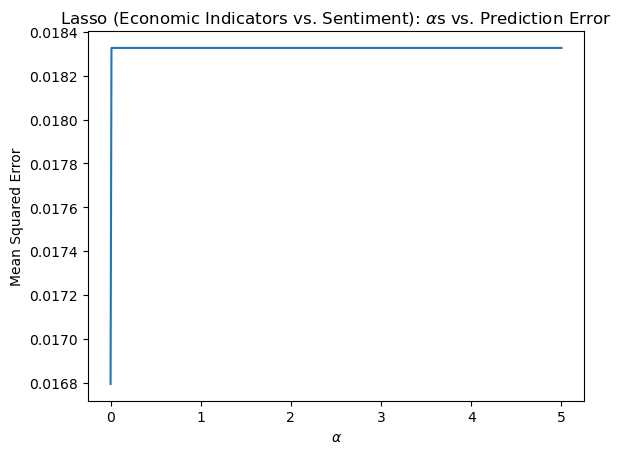

In [38]:
# Conduct LASSO Regression on all indicators

# Split data

working_ys = working_data[dep]
working_xs = working_data[indeps]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Note: Code inspired by and borrowed from review session + homework 2
# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso = None
opt_alpha_lasso = 0
min_MSE = 0
counter = 0

# Define alphas and models
alphas = np.linspace(1e-6, 5, num=500)
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso = alphas[counter]
        opt_coefs_lasso = model['lasso'].coef_
    counter += 1
    
print(opt_alpha_lasso)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (Economic Indicators vs. Sentiment): $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\alphaLASSO.png')
plt.show()

### Ridge

We conduct this analysis for the same reason as LASSO: to assess variable selection and dimension reduction.

0.5811632084168338


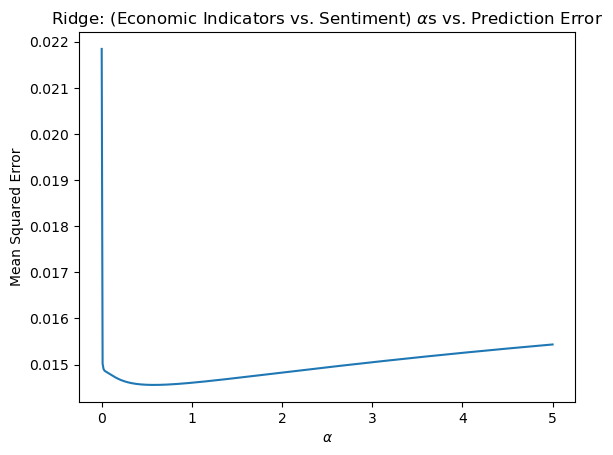

In [39]:
# Conduct Ridge Regression on all indicators

# Drop nan observations and split data

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge = None
opt_alpha_ridge = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge = alphas[counter]
        opt_coefs_ridge = model['ridge'].coef_
    counter += 1
    
print(opt_alpha_ridge)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (Economic Indicators vs. Sentiment) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\alphaRidge.png')
plt.show()

### Coefficient Comparison: OLS vs. LASSO vs. Ridge Regressions

Notice here that the inputs to the LASSO and Ridge regressions are scaled, which leads to non-comparable magnitudes for these regressions. We can interpret LASSO and Ridge coefficients in terms of prediction importance.

In [40]:
# Coefficient comparison

coef_comp = pd.DataFrame({
    'var' : indeps,
    'val_ols' : ols.params.tolist()[1:], 
    'val_lasso' : opt_coefs_lasso, 
    'var_ridge' : opt_coefs_ridge[0]
})

print("Economic Indicators vs. Sentiment")
print(coef_comp)

Economic Indicators vs. Sentiment
                            var   val_ols  val_lasso  var_ridge
0           Real GDP per Capita -0.000865   0.090291  -0.005718
1                      Real GDP  0.002784   0.025911  -0.005154
2                GDP per Capita  0.001069  -0.510261  -0.003380
3                           GDP -0.003390   0.277967  -0.003194
4  Real Median Household Income -0.000046  -0.099315  -0.023081
5       Median Household Income  0.000030   0.099906   0.012557
6                     Inflation -0.033059  -0.032766  -0.008030
7             Unemployment Rate -0.018339  -0.059251  -0.015483
